In [1]:
import bilby
import numpy as np
from bilby.core.utils import random

/work/submit/kyoon/miniforge3/envs/ssm/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
random.seed(123)

In [3]:
data = random.rng.normal(loc=0, scale=1, size=1000)

In [5]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, data):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"mu": None, "sigma": None})
        self.data = data
        self.N = len(data)


    def log_likelihood(self):
        mu = self.parameters["mu"]
        sigma = self.parameters["sigma"]
        res = self.data - mu
        return -0.5 * (
            np.sum((res / sigma) ** 2) + self.N * np.log(2 * np.pi * sigma**2)
        )

In [6]:
likelihood = SimpleGaussianLikelihood(data)
priors = dict(
    mu = bilby.core.prior.Uniform(0, 5, name='mu'),
    sigma = bilby.core.prior.Uniform(0, 10, name='sigma')
)

15:39 bilby INFO    : Running for label 'simple_gaussian', output will be saved to 'outdir'
15:39 bilby INFO    : Analysis priors:
15:39 bilby INFO    : mu=Uniform(minimum=0, maximum=5, name='mu', latex_label='mu', unit=None, boundary=None)
15:39 bilby INFO    : sigma=Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
15:39 bilby INFO    : Analysis likelihood class: <class '__main__.SimpleGaussianLikelihood'>
15:39 bilby INFO    : Analysis likelihood noise evidence: nan
15:39 bilby INFO    : Single likelihood evaluation took 6.455e-05 s
15:39 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
15:39 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:39 bilby WARNING : Using cached result
15:39

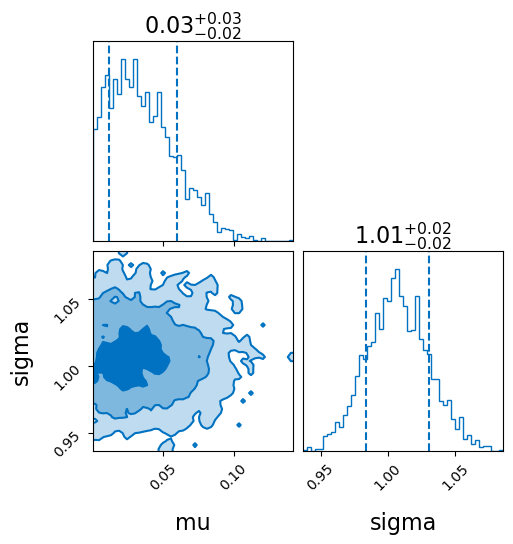

In [7]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler='dynesty',
    npoints=1000,
    outdir='outdir',
    label='simple_gaussian'
)
result.plot_corner()

### Damped Harmonic Oscillator Data

Which likelihood to use? Gaussian noise -> Gaussian likelihood.

In [4]:
import torch
from torch.utils.data import DataLoader
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform

In [5]:
torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [7]:
import sys
import os

datatype = 'SHO'
if datatype == 'SHO':
    sys.path.append(os.path.abspath('../ssm_regression'))
    from data_sho import damped_sho_np as func
    from data_sho import DataGenerator
elif datatype == 'SineGaussian':
    from data_sinegaussian import sine_gaussian_np as func
    from data_sinegaussian import DataGenerator

my_func = func

datadir = f'/ceph/submit/data/user/k/kyoon/KYoonStudy/models/{datatype}'
savedir = '/ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults'
modeldir = os.path.join(datadir, 'models')
test_dict = torch.load(os.path.join(datadir, 'test.pt'), map_location=torch.device('cpu'))
test_data = DataGenerator(test_dict)

/tmp/ipykernel_1123919/690387295.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dict = torch.load(os.path.join(datadir, 'test.pt'), map_location=torch.device('cpu

In [8]:
test_data_loader = DataLoader(
    test_data, batch_size=1, num_workers=0,
    shuffle=False,
)
t_vals_np = np.linspace(start=-1, stop=10, num=200)

Setup priors.

In [9]:
priors = {}
if datatype=='SHO':
    priors['omega_0'] = Uniform(0.1, 1.9, name='omega_0', latex_label=r'$\omega_0$')
    priors['beta'] = Uniform(0, 0.5, name='beta', latex_label=r'$\beta$')
    injection_parameters = dict(omega_0=1., beta=0.3)
elif datatype=='SineGaussian':
    priors['f_0'] = Uniform(0.1, 1.9, name='f_0', latex_label=r'$f_0$')
    priors['tau'] = Uniform(1., 4., name='tau', latex_label=r'$\tau$')
    injection_parameters = dict(f_0=1., tau=2.5)

Run bilby on a single event.

In [10]:
theta_u0, theta_s0, data_u0, data_s0 = next(iter(test_data_loader))

In [11]:
y = data_u0[0][0].to('cpu')
y_np = y.numpy()

In [12]:
log_l = GaussianLikelihood(t_vals_np, y_np, my_func, sigma=0.4, shift=1)

In [22]:
result = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=50, npool=4, save=True, clean=True,
    injection_parameters=injection_parameters,
    outdir=savedir,
    label=datatype
)

18:55 bilby INFO    : Running for label 'SHO', output will be saved to '/ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults'
18:55 bilby INFO    : Analysis priors:
18:55 bilby INFO    : omega_0=Uniform(minimum=0.1, maximum=1.9, name='omega_0', latex_label='$\\omega_0$', unit=None, boundary=None)
18:55 bilby INFO    : beta=Uniform(minimum=0, maximum=0.5, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
18:55 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
18:55 bilby INFO    : Analysis likelihood noise evidence: nan
18:55 bilby INFO    : Single likelihood evaluation took 1.916e-04 s
18:55 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 50, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': N

416it [00:02, 145.59it/s, bound:10 nc: 20 ncall:7.6e+03 eff:5.5% logz=-101.06+/-0.32 dlogz:0.127>0.1]

18:55 bilby INFO    : Written checkpoint file /ceph/submit/data/user/k/kyoon/KYoonStudy/fitresults/SHO_resume.pickle
18:55 bilby INFO    : Starting to close worker pool.
18:55 bilby INFO    : Finished closing worker pool.


427it [00:05, 77.98it/s, bound:10 nc:  1 ncall:7.8e+03 eff:6.2% logz=-100.94+/-0.32 dlogz:0.00186>0.1]

18:55 bilby INFO    : Rejection sampling nested samples to obtain 149 posterior samples
18:55 bilby INFO    : Sampling time: 0:00:05.439007
18:55 bilby INFO    : Summary of results:
nsamples: 149
ln_noise_evidence:    nan
ln_evidence: -100.941 +/-  0.364
ln_bayes_factor:    nan +/-  0.364



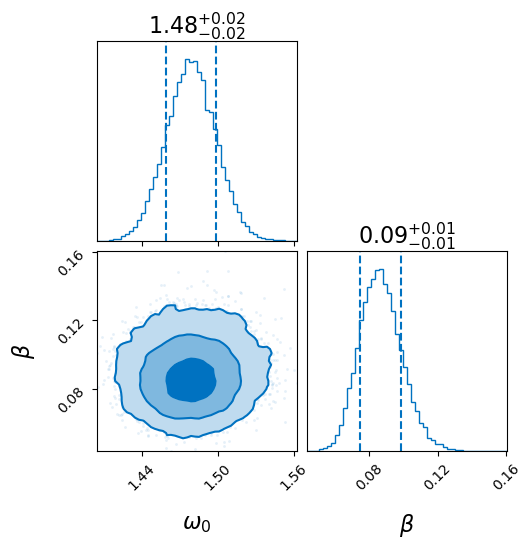

In [17]:
result.plot_corner()

In [18]:
theta_u0

tensor([[[1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000],
         [1.4496, 0.0802, 1.0000]]], device='cuda:0')

What if I don't fix my sigma?

In [19]:
priors_nosigma = {}
priors_nosigma['omega_0'] = Uniform(0.1, 1.9, name='omega_0', latex_label=r'$\omega_0$')
priors_nosigma['beta'] = Uniform(0, 0.5, name='beta', latex_label=r'$\beta$')
priors_nosigma['sigma'] = Uniform(0, 1., name='sigma', latex_label=r'$\sigma$')
injection_parameters_nosigma = dict(omega_0=1., beta=0.3, sigma=0.4)

15:44 bilby INFO    : Running for label 'SHO', output will be saved to 'outdir'
15:44 bilby INFO    : Analysis priors:
15:44 bilby INFO    : omega_0=Uniform(minimum=0.1, maximum=1.9, name='omega_0', latex_label='$\\omega_0$', unit=None, boundary=None)
15:44 bilby INFO    : beta=Uniform(minimum=0, maximum=0.5, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
15:44 bilby INFO    : sigma=Uniform(minimum=0, maximum=1.0, name='sigma', latex_label='$\\sigma$', unit=None, boundary=None)
15:44 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
15:44 bilby INFO    : Analysis likelihood noise evidence: nan
15:44 bilby INFO    : Single likelihood evaluation took 1.651e-04 s
15:44 bilby WARNING : Supplied argument 'output_dir' not an argument of 'Dynesty', removing.
15:44 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 10000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'fir

118142it [06:12, 337.22it/s, bound:3685 nc:  1 ncall:2.8e+06 eff:4.6% logz=-104.14+/-0.03 dlogz:9.65e-06>0.1]

15:51 bilby INFO    : Written checkpoint file outdir/SHO_resume.pickle
15:51 bilby INFO    : Starting to close worker pool.
15:51 bilby INFO    : Finished closing worker pool.


118142it [07:24, 265.76it/s, bound:3685 nc:  1 ncall:2.8e+06 eff:4.6% logz=-104.14+/-0.03 dlogz:9.65e-06>0.1]



15:51 bilby INFO    : Rejection sampling nested samples to obtain 32999 posterior samples
15:51 bilby INFO    : Sampling time: 0:07:24.481081
15:51 bilby INFO    : Summary of results:
nsamples: 32999
ln_noise_evidence:    nan
ln_evidence: -104.142 +/-  0.039
ln_bayes_factor:    nan +/-  0.039



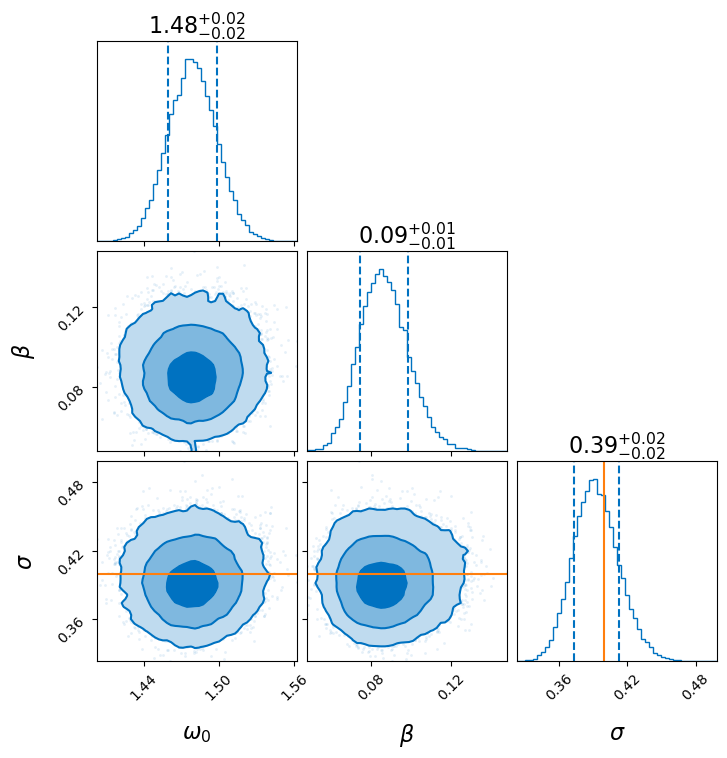

In [ ]:
log_l_nosigma = GaussianLikelihood(t_vals_np, y_np, my_func, shift=1)
result_nosigma = bilby.run_sampler(
    likelihood=log_l_nosigma, priors=priors_nosigma, sampler='dynesty',
    nlive=10000, npool=4, save=True, clean=True,
    injection_parameters=injection_parameters_nosigma,
    outdir=savedir,
    label=datatype
)
result_nosigma.plot_corner()

What if I use the truth values for injection parameters?

In [21]:
injection_parameters_truth = dict(omega_0=1.4496, beta=0.0802)

15:51 bilby INFO    : Running for label 'SHO', output will be saved to 'outdir'


15:51 bilby INFO    : Analysis priors:
15:51 bilby INFO    : omega_0=Uniform(minimum=0.1, maximum=1.9, name='omega_0', latex_label='$\\omega_0$', unit=None, boundary=None)
15:51 bilby INFO    : beta=Uniform(minimum=0, maximum=0.5, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
15:51 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
15:51 bilby INFO    : Analysis likelihood noise evidence: nan
15:51 bilby INFO    : Single likelihood evaluation took 1.343e-04 s
15:51 bilby WARNING : Supplied argument 'output_dir' not an argument of 'Dynesty', removing.
15:51 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 10000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'g

87186it [03:53, 404.42it/s, bound:1643 nc:  1 ncall:1.4e+06 eff:6.9% logz=-101.21+/-0.02 dlogz:9.56e-06>0.1]

15:56 bilby INFO    : Written checkpoint file outdir/SHO_resume.pickle
15:56 bilby INFO    : Starting to close worker pool.
15:56 bilby INFO    : Finished closing worker pool.


87186it [04:45, 305.33it/s, bound:1643 nc:  1 ncall:1.4e+06 eff:6.9% logz=-101.21+/-0.02 dlogz:9.56e-06>0.1]

15:56 bilby INFO    : Rejection sampling nested samples to obtain 27209 posterior samples
15:56 bilby INFO    : Sampling time: 0:04:45.477001


15:56 bilby INFO    : Summary of results:
nsamples: 27209
ln_noise_evidence:    nan
ln_evidence: -101.206 +/-  0.032
ln_bayes_factor:    nan +/-  0.032



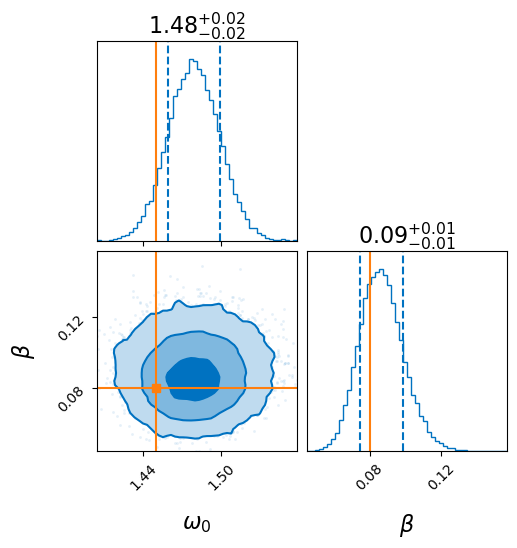

In [ ]:
result_injecttruth = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=10000, npool=4, save=True, clean=True,
    injection_parameters=injection_parameters_truth,
    outdir=savedir,
    label=datatype
)
result_injecttruth.plot_corner()